In [160]:
import spacy
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
import numpy as np
import random
from sklearn.preprocessing import normalize
random.seed(42)
import spacy
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import dspy
from nltk.stem import PorterStemmer
nltk.download('punkt')
from datasets import Dataset
nltk.download('stopwords')
from transformers import pipeline
import ast
import json


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [228]:
def create_category_string(category, dictionary):
    string = f"{category}: "
    
    if category in dictionary:
        category_data = dictionary[category]
        if isinstance(category_data, list):
            for item in category_data:
                for k, v in item.items():
                    if k == 'name':  
                        continue
                    if isinstance(v, list):
                        v = ', '.join(v)
                    string += f"{k}: {v} "
        elif isinstance(category_data, dict):
            for k, v in category_data.items():
                if k == 'name': 
                    continue
                if isinstance(v, list):
                    v = ', '.join(v)
                string += f"{k}: {v} "
        else:
            string += f"{category}: {category_data} "
    
    return string#.replace(":","").replace(".","").replace(",","")



def transform_dict_to_string(data):
    full_string = ""

    for category in data:
        full_string += create_category_string(category, data)
        full_string += " "
    
    return full_string.strip()




In [163]:
from transformers import pipeline
from collections import defaultdict
import re
from tqdm import tqdm

class CharacterAnonymizer:
    def __init__(self, batch_size=16):
        self.ner_pipeline = pipeline(
            "ner",
            model="Jean-Baptiste/roberta-large-ner-english",
            aggregation_strategy="simple",
            device=0 
        )
        self.batch_size = batch_size

    def normalize_name(self, name):
        """Normalize name: lowercase, remove punctuation."""
        name = name.lower()
        name = re.sub(r"[^a-z ]", "", name)
        return name.strip()

    def extract_names_batch(self, texts):
        """Run NER in batch and extract PERSON names per document."""
        ner_results_batch = self.ner_pipeline(texts)
        all_names = []
        for ner_results in ner_results_batch:
            names = [ent['word'] for ent in ner_results if ent['entity_group'] == 'PER']
            normalized = list(set(self.normalize_name(name) for name in names))
            all_names.append(normalized)
        return all_names

    def cluster_names(self, names):
        """Cluster similar names by shared first tokens."""
        clusters = defaultdict(list)
        used = set()

        for name in names:
            if not name.strip():
                continue
            if name in used:
                continue
            parts = name.split()
            if not parts:
                continue
            key = parts[0]
            for other in names:
                if key in other and other not in used:
                    clusters[key].append(other)
                    used.add(other)
        return clusters

    def generate_name_map(self, clusters):
        """Create CharacterN mapping for each name variant."""
        name_map = {}
        for i, (key, variants) in enumerate(clusters.items(), start=1):
            tag = f"Character{i}"
            for name in variants:
                name_map[name] = tag
        return name_map

    def replace_names(self, text, name_map):
        """Replace all name variants in the original text with CharacterN."""
        for original in sorted(name_map.keys(), key=len, reverse=True):
            pattern = re.compile(rf'\b{re.escape(original)}\b', re.IGNORECASE)
            text = pattern.sub(name_map[original], text)
        return text

    def anonymize_batch(self, texts):
        """Anonymize texts in batches with a progress bar."""
        anonymized_texts = []

        for i in tqdm(range(0, len(texts), self.batch_size), desc="Anonymizing"):
            batch = texts[i:i + self.batch_size]
            all_names = self.extract_names_batch(batch)

            for text, names in zip(batch, all_names):
                clusters = self.cluster_names(names)
                name_map = self.generate_name_map(clusters)
                anonymized = self.replace_names(text, name_map)
                anonymized_texts.append(anonymized)

        return anonymized_texts


In [255]:
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi

def build_index(embeddings, normalize_vectors=True):
    if normalize_vectors:
        return normalize(embeddings, axis=1)
    return embeddings

def get_dense_similarity(query_vector, candidate_vectors):
    return np.dot(candidate_vectors, query_vector.T).flatten()

def get_bm25_scores(corpus, query, bm25=None):
    if bm25 is None:
        bm25 = BM25Okapi([doc for doc in corpus])
    return bm25.get_scores(query)

def get_relevance_scores(i, labels, data, index, k=None, method='dense', bm25=None):
    if k is None:
        k = len(labels)

    query_label = labels[i]
    matching_labels = np.where(np.array(labels) == query_label)[0]

    if method == 'dense':
        query_vector = index[i].reshape(1, -1)
        similarities = get_dense_similarity(query_vector, index)
    elif method == 'bm25':
        query_text = data[i]
        similarities = get_bm25_scores(data, query_text, bm25)
    else:
        raise ValueError("Unsupported method. Use 'dense' or 'bm25'.")

    top_k_indices = np.argsort(similarities)[::-1]
    top_k_indices = top_k_indices[top_k_indices != i][:k]

    relevance_scores = [1 if x in matching_labels else 0 for x in top_k_indices]
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    return ideal_relevance_scores, relevance_scores

def calculate_mean_ndcg_score(labels, data, embeddings=None, method='dense'):
    if method == 'dense':
        embeddings = np.array(embeddings).astype('float32')
        index = build_index(embeddings)
        get_index = lambda: index
        bm25 = None
    elif method == 'bm25':
        index = data
        get_index = lambda: index
        bm25 = BM25Okapi([doc for doc in data])
    else:
        raise ValueError("Method must be 'dense' or 'bm25'.")

    ideal_relevance_scores = []
    relevance_scores = []

    for i in [labels.index(x) for x in list(set(labels))]:
        irs, rs = get_relevance_scores(i, labels, data, get_index(), method=method, bm25=bm25)
        ideal_relevance_scores.append(irs)
        relevance_scores.append(rs)

    return ndcg_score(np.array(ideal_relevance_scores), np.array(relevance_scores))


In [256]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
embedder = dspy.Embedder(model.encode)
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


In [257]:
df = pd.read_excel("data/tell_me_again_df_with_elements_v3.xlsx")

In [258]:
labels = df.label.tolist()
texts = df["extracted_elements"].tolist()

In [259]:
texts = [transform_dict_to_string(json.loads(text)) for text in df["extracted_elements"].tolist()]

In [264]:
df

,level_0,index,Unnamed: 0,wikidata_id,title,language,unpacked_summary,unpacked_summary_sents,label,property_count,extracted_elements,text
0,6,54944,54944,Q426517,...And Justice for All,es,"Arthur Kirkland (Al Pacino), a defense attorne...","['Arthur Kirkland (Al Pacino), a defense attor...",19,3,"{""characters"": [\n {\n ""name"": ""Character1...","Character15 (Character2), a defense attorney i..."
1,7,54941,54941,Q426517,...And Justice for All,de,Idealistic lawyer Arthur Kirkland defends soci...,"[""Idealistic lawyer Arthur Kirkland defends so...",19,3,"{""characters"": [\n {""name"": ""Character1"", ""ro...",Idealistic lawyer Character2 defends society's...
2,8,54943,54943,Q426517,...And Justice for All,it,Arthur Kirkland is an honest Baltimore lawyer ...,['Arthur Kirkland is an honest Baltimore lawye...,19,3,"{""characters"": [\n {""name"": ""Character1"", ""ro...",Character10 is an honest Baltimore lawyer with...
3,13,46540,46540,Q3023357,12 Years a Slave,fr,"In 1841, Solomon Northup was a free man living...","['In 1841, Solomon Northup was a free man livi...",72,3,"{""characters"": [\n {\n ""name"": ""Character4...","In 1841, Character6 was a free man living with..."
4,14,46542,46542,Q3023357,12 Years a Slave,es,"In 1841, Solomon Northup is a free black man l...","['In 1841, Solomon Northup is a free black man...",72,3,"{""characters"": [\n {""name"": ""Character1"", ""ro...","In 1841, Character5 is a free black man living..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3375,5956,1673,1673,Q1059553,Zorba the Greek,es,"The book begins in a cafe in Piraeus, just bef...","['The book begins in a cafe in Piraeus, just b...",27304,3,"{""characters"": [\n {\n ""name"": ""Narrator"",...","The book begins in a cafe in Piraeus, just bef..."
3376,5958,76417,76417,Q818710,Zorba the Greek,de,"The time of the film's action is uncertain, it...","[""The time of the film's action is uncertain, ...",27304,3,"{""characters"": [\n {""name"": ""Character3"", ""ro...","The time of the film's action is uncertain, it..."
3377,5960,37782,37782,Q228867,Zulu,es,Following the disaster for the British Army at...,['Following the disaster for the British Army ...,27311,3,"{""characters"": [\n {\n ""name"": ""Lieutenant...",Following the disaster for the British Army at...
3378,5959,37779,37779,Q228867,Zulu,de,"In 1879, the British government was informed t...","['In 1879, the British government was informed...",27311,3,"{""characters"": [\n {\n ""name"": ""Character2...","In 1879, the British government was informed t..."


In [260]:
texts[0]

"characters: role: protagonist backstory: Defense attorney in Baltimore, facing contempt of court after beating Judge Henry T. Character11. weaknesses: Stymied by Character1's efforts to review the case., Unstable friend and partner (Character16). strengths: Logical, strategic., Determined to defend innocence. motivations: Protecting innocence., Seeking redemption., Revenge (potentially). role: antagonist backstory: Poor protagonist, acquired power, wealth, and a mate before losing it all. weaknesses: Self-centered., Unreliable., Driven by ego. strengths: Resourceful., Manipulative. motivations: Gain power and wealth., Protecting his own interests. role: protagonist backstory: Abandoned by his parents, raised by Character1, sent to law school. weaknesses: Naive., Dependent on Character1. strengths: Compassionate., Knowledgeable. motivations: Protecting his son., Providing a stable environment. role: protagonist backstory: Transformed transformer, arrested for a misdemeanor traffic viol

In [265]:
embeddings = embedder(texts)

In [266]:
ndcg_dense = calculate_mean_ndcg_score(labels, data=texts, embeddings=embeddings, method='dense')

In [267]:
ndcg_dense

np.float64(0.7273867732174578)

C:\Users\emiel\AppData\Local\Temp\ipykernel_12368\4193770804.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_palette = plt.cm.get_cmap("Set2", len(df.index))


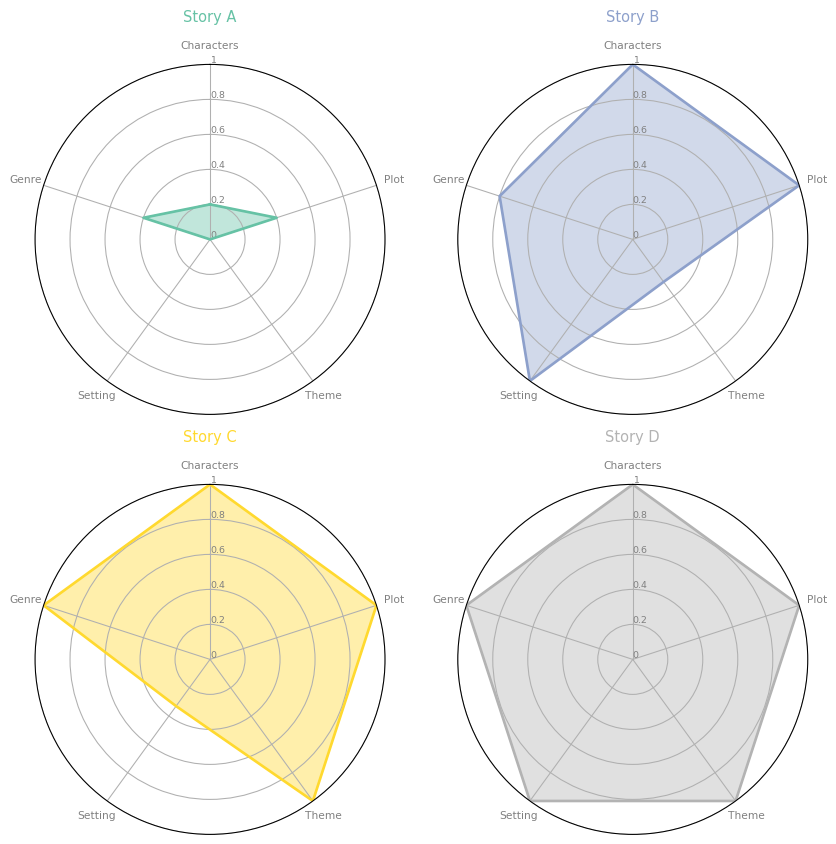

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
df = pd.DataFrame({
'group': ['A','B','C','D'],
'Characters': [0.2, 1, 1, 1],
'Plot': [0.4, 1, 1, 1],
'Theme': [0, 0.3, 1, 1],
'Setting': [0,1 , 0.33, 1],
'Genre': [0.4, 0.8, 1, 1]
})
 
 
def make_spider( row, title, color):

    categories=list(df)[1:]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(2,2,row+1, polar=True, )

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)

    ax.set_rlabel_position(0)
    plt.yticks([0,0.2,0.4,0.6,0.8,1], ["0","0.2","0.4", "0.6", "0.8", "1"], color="grey", size=7)
    plt.ylim(0,1)

    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    plt.title(title, size=11, color=color, y=1.1)

    

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
for row in range(0, len(df.index)):
    make_spider( row=row, title='Story '+df['group'][row], color=my_palette(row))